# Imports

In [28]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

# Load Data

In [2]:
# List all data available
datapath = r'../assets'
os.listdir(datapath)

['text.md',
 'datagov_dengue.csv',
 '.ipynb_checkpoints',
 'google_trend_dengue.csv',
 'google_trend_dengue_symptoms.csv',
 'jao_dengue.csv',
 'NEA_weather.csv',
 'datagov_weather.csv',
 'NEA_dengue.csv']

Loading all data for cleaning and compiling

In [3]:
# Dengue
df_dengue_datagov_raw = pd.read_csv(os.path.join(datapath,'datagov_dengue.csv'))
df_dengue_jao_raw = pd.read_csv(os.path.join(datapath,'jao_dengue.csv'))
df_dengue_NEA_raw = pd.read_csv(os.path.join(datapath,'NEA_dengue.csv'))

# Weather
df_weather_datagov_raw = pd.read_csv(os.path.join(datapath,'datagov_weather.csv'))
df_weather_NEA_raw = pd.read_csv(os.path.join(datapath,'NEA_weather.csv'))

# Google trend
df_trend_dengue_raw = pd.read_csv(os.path.join(datapath,'google_trend_dengue.csv'))
df_trend_dengue_symptoms_raw = pd.read_csv(os.path.join(datapath,'google_trend_dengue_symptoms.csv'))

We first clean and compile the available __dengue__ data. Most years have 52 or 53 weeks, while 2024 only has 27 weeks so far. 2019 has some missing entries which will require some imputation later.

In [4]:
# Clean and compile dengue data
df_dengue_datagov = df_dengue_datagov_raw.copy()
df_dengue_datagov.rename(columns={'year':'Year','eweek':'Week','number':'Dengue_Count'}, inplace=True)    # Rename columns for consistency
df_dengue_datagov = df_dengue_datagov.groupby(['Year','Week']).sum()                                      # Combine normal dengue cases and hemorrhagic cases
df_dengue_datagov = df_dengue_datagov.drop(columns='type_dengue').reset_index()                           # Drop dengue fever type

df_dengue_jao = df_dengue_jao_raw.copy()
df_dengue_jao.rename(columns={'Week No.':'Week', 'Dengue (Count)':'Dengue_Count'},inplace=True)           # Rename columns for consistency
df_dengue_jao.drop(columns=['Daily Rainfall Total (mm)','Mean Temperature (C)'],inplace=True)

df_dengue_NEA = df_dengue_NEA_raw.copy()
df_dengue_NEA = df_dengue_NEA.reset_index()
df_dengue_NEA.drop(columns='Unnamed: 0',inplace=True)
df_dengue_NEA = pd.melt(df_dengue_NEA, id_vars=['index','week'],
                        value_vars=['2020','2021','2022','2023','2024'],
                        var_name='Year', value_name='Dengue_Count')                                       # Gathering into long format for consistency
df_dengue_NEA.drop(columns=['index'],inplace=True)
df_dengue_NEA.rename(columns={'week':'Week'},inplace=True)                                                # Rename columns for consistency

df_dengue = pd.concat([df_dengue_datagov,df_dengue_NEA,df_dengue_jao],axis=0)                             # Compiling all dengue datasets into single dataframe
df_dengue.dropna(inplace=True)                                                                            # Dropping small number of missing values
df_dengue = df_dengue.astype({'Year':'int', 'Dengue_Count':'int'})                                        # Converting to standard dtypes
df_dengue.drop_duplicates(subset=['Year','Week'],inplace=True)                                            # Dropping duplicate entries from different data sources
df_dengue.sort_values(by=['Year','Week'],inplace=True)                                                    # Sort in chronological order
df_dengue.groupby(['Year']).count()

,Week,Dengue_Count
Year,,
2012,52,52
2013,52,52
2014,53,53
2015,53,53
2016,53,53
2017,53,53
2018,53,53
2019,47,47
2020,53,53


Next, we clean and compile the __weather__ data. On further inpection, we see that the datagov data consists of weather information for years from 2009 to 2017 only.

In [5]:
# Show data structure and date range
df_weather_datagov = df_weather_datagov_raw.copy()
display(df_weather_datagov.head(5))
pd.to_datetime(df_weather_datagov['date']).min(), pd.to_datetime(df_weather_datagov['date']).max()

,date,station,daily_rainfall_total,highest_30_min_rainfall,highest_60_min_rainfall,highest_120_min_rainfall,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed
0,2009-01-01,Admiralty,na,na,na,na,na,na,na,na,na
1,2009-01-02,Admiralty,na,na,na,na,na,na,na,na,na
2,2009-01-03,Admiralty,na,na,na,na,na,na,na,na,na
3,2009-01-04,Admiralty,na,na,na,na,na,na,na,na,na
4,2009-01-05,Admiralty,na,na,na,na,na,na,na,na,na


(Timestamp('2009-01-01 00:00:00'), Timestamp('2017-11-30 00:00:00'))

Since we need data from 2012 to 2024, we will not use the datagov weather data, and focus on NEA weather instead, which has been scraped from NEA for the required date range. Missing data has been encoded as -1 in this dataset. As shown, the NEA dataset contains daily weather information information from multiple weather stations.

In [6]:
df_weather_NEA = df_weather_NEA_raw.copy()
df_weather_NEA.sample(5)

,Unnamed: 0,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
75881,9,Queenstown,2022,10,10,2.4,1.8,1.8,1.8,-1.0,-1.0,-1.0,-1.0,-1.0
127125,5,Jurong Pier,2013,10,6,25.4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
13017,5,Buangkok,2014,3,6,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
162643,8,Boon Lay (West),2017,3,9,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
239152,1,Queenstown,2016,4,2,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0


Our dengue dataset provides weekly dengue counts for the whole of Singapore. To match the dengue dataset, we take the mean values for the different weather conditions across different weather stations and over the week. We see that the highest rainfall columns consists of more than 100 missing values. These columns are dropped here for simplicity.

In [7]:
df_weather_NEA.columns

Index(['Unnamed: 0', 'Station', 'Year', 'Month', 'Day',
       'Daily Rainfall Total (mm)', 'Highest 30 min Rainfall (mm)',
       'Highest 60 min Rainfall (mm)', 'Highest 120 min Rainfall (mm)',
       'Mean Temperature (°C)', 'Maximum Temperature (°C)',
       'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Max Wind Speed (km/h)'],
      dtype='object')

In [8]:
# Get week of year
df_weather_NEA = df_weather_NEA.replace(-1, np.nan)                                     # Encode missing values as NaN
df_weather_NEA.drop(columns=['Unnamed: 0'],inplace=True)                                # Drop index column
df_weather_NEA.dropna(subset=['Year','Month','Day'],inplace=True)                       # Dropping records where the date in missing
df_weather_NEA = df_weather_NEA.astype({'Year':'int','Month':'int','Day':'int'})        # Convert to date time and extract week of year
df_weather_NEA['date'] = pd.to_datetime(df_weather_NEA[['Year', 'Month', 'Day']])
df_weather_NEA['Week'] = df_weather_NEA['date'].dt.isocalendar().week
df_weather_NEA.drop(columns=['Month','Day','date','Station'],inplace=True)                        # Drop obsolete columns

# Renaming columns for convenience.
df_weather_NEA.rename(columns={'Daily Rainfall Total (mm)':'Daily_Rainfall',
                               'Highest 30 min Rainfall (mm)':'Highest_30mm_Rain',
                               'Highest 60 min Rainfall (mm)':'Highest_60mm_Rain',
                               'Highest 120 min Rainfall (mm)':'Highest_120mm_Rain',
                               'Mean Temperature (°C)':'Mean_Temperature',
                               'Maximum Temperature (°C)':'Max_Temperature',
                               'Minimum Temperature (°C)':'Min_Temperature',
                               'Mean Wind Speed (km/h)':'Min_Wind_Speed',
                               'Max Wind Speed (km/h)':'Max_Wind_speed'},inplace=True)

# Taking mean values over all stations and over all days of a given week
df_weather_NEA = df_weather_NEA.groupby(['Year','Week']).mean()

# Check for missing values and drop
print(df_weather_NEA.info())
df_weather_NEA.drop(columns=[col for col in df_weather_NEA if ('Highest' in col)], inplace=True)
df_weather = df_weather_NEA.reset_index()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 654 entries, (np.int64(2012), np.uint32(1)) to (np.int64(2024), np.uint32(26))
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Daily_Rainfall      654 non-null    float64
 1   Highest_30mm_Rain   550 non-null    float64
 2   Highest_60mm_Rain   550 non-null    float64
 3   Highest_120mm_Rain  550 non-null    float64
 4   Mean_Temperature    654 non-null    float64
 5   Max_Temperature     654 non-null    float64
 6   Min_Temperature     654 non-null    float64
 7   Min_Wind_Speed      654 non-null    float64
 8   Max_Wind_speed      654 non-null    float64
dtypes: float64(9)
memory usage: 47.7 KB
None


The final dataframe to be used as weather input is as shown below.

In [9]:
df_weather.sample(5)

,Year,Week,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed
0,2012,1,10.266250,26.866026,30.521875,24.589375,10.653125,36.228750
556,2022,33,9.604954,28.137815,31.417647,25.208403,7.357627,34.568908
199,2015,44,6.213759,27.885401,32.105036,24.980576,6.806475,30.491367
613,2023,38,12.504983,27.806250,31.710714,24.998214,7.396639,32.910924
310,2017,49,5.176045,27.667033,31.505051,25.400000,7.670175,29.726316


Finally, __google search trends__ regarding dengue may indicate imminent occurence of dengue clusters. Specifically, we include search trends related to the keywords "dengue" and "dengue+symptoms".

In [10]:
# Renaming columns
df_trend_dengue = df_trend_dengue_raw.copy()
df_trend_dengue_symptoms = df_trend_dengue_symptoms_raw.copy()
df_trend_dengue.rename(columns={'dengue: (Singapore)':'Trend_Dengue'},inplace=True)
df_trend_dengue_symptoms.rename(columns={'dengue symptoms: (Singapore)':'Trend_Dengue_Symptoms'},inplace=True)

# Get week and year
df_trend_dengue['Year'] = pd.to_datetime(df_trend_dengue['Week']).dt.isocalendar().year
df_trend_dengue['Week'] = pd.to_datetime(df_trend_dengue['Week']).dt.isocalendar().week
df_trend_dengue_symptoms['Year'] = pd.to_datetime(df_trend_dengue_symptoms['Week']).dt.isocalendar().year
df_trend_dengue_symptoms['Week'] = pd.to_datetime(df_trend_dengue_symptoms['Week']).dt.isocalendar().week

# Combining into one dataframe
df_trends = df_trend_dengue.merge(df_trend_dengue_symptoms,how='left',on=['Week','Year'])
df_trends.drop_duplicates(subset=['Year','Week'],inplace=True) # Drop small number of repeated entries
df_trends

,Week,Trend_Dengue,Year,Trend_Dengue_Symptoms
0,52,51,2014,58
2,1,51,2015,74
3,2,51,2015,66
4,3,49,2015,60
5,4,62,2015,62
...,...,...,...,...
680,24,63,2024,59
681,25,63,2024,77
682,26,58,2024,76
683,27,57,2024,73


We combined all data we have into a single dataframe. Visualizing missing data, we see that most of them are due to consideration of a 53rd week of the year. As mentioned earlier, some weeks in 2019 are missing dengue fever counts. Here, we:
1. drop 53rd week from each year
2. fill the missing values with `.ffill` methods.

In [11]:
df_raw= df_dengue.merge(df_weather,on=['Year','Week'],how='outer').merge(df_trends,on=['Year','Week'],how='outer')
display(df_raw[df_raw.isna().any(axis=1)])   # Show rows with missing values

,Year,Week,Dengue_Count,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Trend_Dengue,Trend_Dengue_Symptoms
0,2011,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,72.0
157,2014,53,158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,2016,53,0.0,9.947647,26.211667,27.990000,24.400000,7.458333,34.603333,NaN,NaN
316,2017,53,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369,2018,53,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417,2019,48,NaN,13.375069,27.664486,32.569027,25.070796,7.818033,33.086066,40.0,39.0
418,2019,49,NaN,6.549143,27.418868,30.736036,25.310811,11.496610,39.640678,40.0,40.0
419,2019,50,NaN,27.321003,25.009091,27.382692,23.375000,9.198214,32.920536,39.0,35.0
420,2019,51,NaN,5.785920,26.448889,30.261458,24.387500,8.639167,30.013333,43.0,57.0
421,2019,52,NaN,2.205525,27.395050,31.543925,25.035514,10.892683,33.669106,22.0,28.0


In [12]:
# Final touches
df_raw = df_raw.loc[df_raw['Week']!=53]
df_raw.ffill(inplace=True)                                        # Fill missing values
df_raw.dropna(inplace=True)                                       # Remove straggling row with missing values
df_raw = df_raw.astype({'Week':'int','Year':'int'})               # Ensure clean datatypes

# Exploratory Data Analysis (EDA)

In [13]:
# Create copy of main dataframe and show structure
df_plot = df_raw.copy()
df_plot.sample(5)

,Year,Week,Dengue_Count,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Trend_Dengue,Trend_Dengue_Symptoms
235,2016,25,213.0,6.918254,28.387597,31.620301,25.723308,7.690226,33.062406,44.0,49.0
158,2015,1,257.0,0.143103,26.950000,30.065789,24.664474,10.061111,32.661111,51.0,74.0
274,2017,11,35.0,3.393531,27.937615,32.055932,25.303390,7.717460,30.410317,85.0,58.0
338,2018,22,54.0,13.991328,27.861538,31.374336,24.783186,6.292857,32.604762,57.0,58.0
438,2020,17,398.0,8.240533,28.584545,33.193913,25.966957,8.298374,32.378689,22.0,18.0


In [14]:
# Confirm that there are no missing values.
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 652 entries, 1 to 660
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   652 non-null    int64  
 1   Week                   652 non-null    int64  
 2   Dengue_Count           652 non-null    float64
 3   Daily_Rainfall         652 non-null    float64
 4   Mean_Temperature       652 non-null    float64
 5   Max_Temperature        652 non-null    float64
 6   Min_Temperature        652 non-null    float64
 7   Min_Wind_Speed         652 non-null    float64
 8   Max_Wind_speed         652 non-null    float64
 9   Trend_Dengue           652 non-null    float64
 10  Trend_Dengue_Symptoms  652 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 61.1 KB


First, we look into the trends of dengue fever over the years. As shown, most years show a peak in the middle of the year, with years 2019, 2020 and 2022 showing higher than usual dengue fever cases, possibly related to Covid related lockdown. Year 2023 again shows lower dengue fever cases as lockdown restrictions are lifted. A peculiar case of low cases is shown for year 2021.

<Axes: xlabel='Week', ylabel='Dengue_Count'>

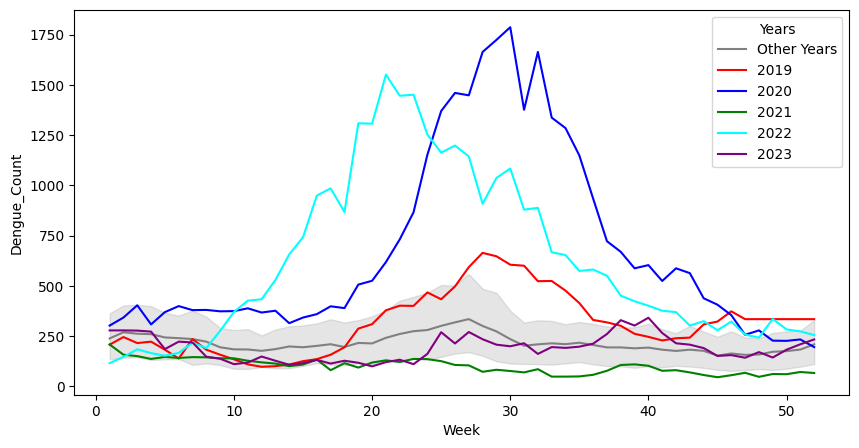

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
key_years = [2019,2020,2021,2022,2023]
df_plot['Years'] = df_plot['Year'].apply(lambda x: str(x) if x in key_years else 'Other Years')
palette = {'Other Years': 'gray', '2019': 'red', '2020':'blue','2021':'green','2022':'cyan','2023':'purple'}
sns.lineplot(data=df_plot, x='Week', y='Dengue_Count', hue='Years', palette=palette, legend=True,ax=ax)

We look at typical variation in dengue cases over a year.

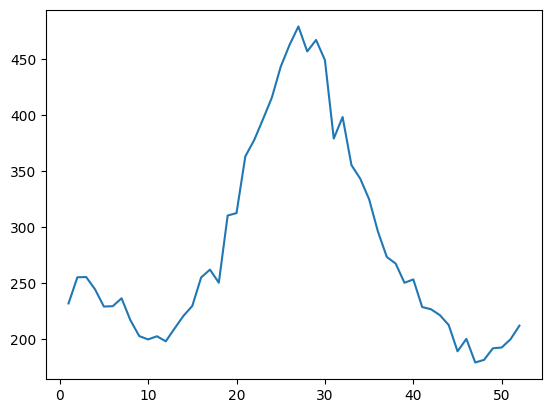

In [17]:
plt.plot(df_plot[['Week', 'Dengue_Count']].groupby('Week').mean())

Using a heatmap of linear correlation, we look at the relationship between dengue cases and the different temperature conditions. We see some correlation with temperature. However, linear relationships may not fully capture the complexity of dengue incidence in response to weather changes. In particular, dengue cases may be related to past weather conditions, as an Aedes egg can take 7 to 10 days to hatch and develop into an adult mosquito. Such relationships can be more properly explored in via statistical modelling.

<Axes: >

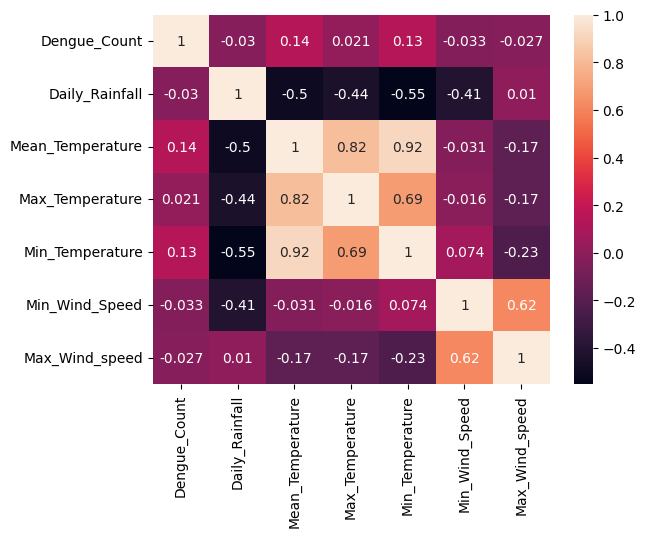

In [18]:
sns.heatmap(df_plot[['Dengue_Count','Daily_Rainfall', 'Mean_Temperature',
       'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
       'Max_Wind_speed']].corr(),annot=True)

Finally, we see if there is a relationship between google search trends on Dengue and incidence of Dengue fever. As shown, there is a strong correlation between search for Dengue symptoms and Dengue fever incidence.

<Axes: >

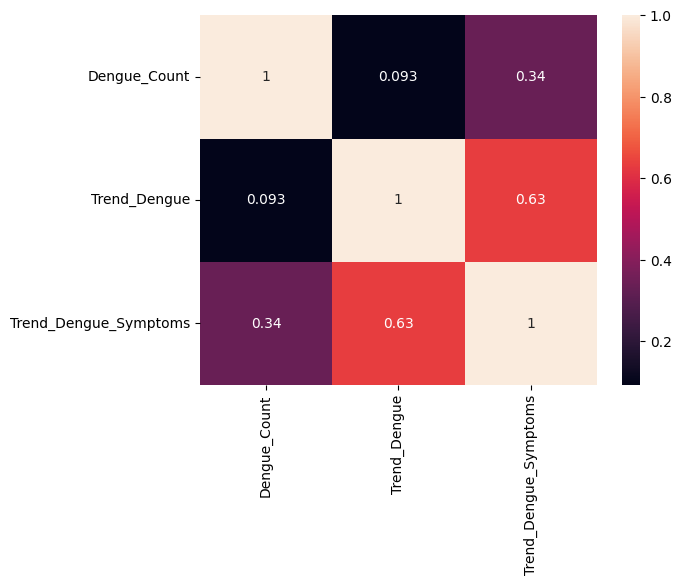

In [19]:
sns.heatmap(df_plot[['Dengue_Count','Trend_Dengue', 'Trend_Dengue_Symptoms']].corr(),annot=True)

# Modelling

## Gradient Boosted Machines (GBM) - XGBoost

We use the XGBoost model here to forecast the occurence of Dengue Fever. To do this, we need to make use of past feature values. Here, we consider a lag of 5 weeks for all features and create a model to predict dengue cases one week in the future.

In [25]:
# Make feature dataset with lagged values.
df_xgb = df_raw.copy()
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_lag_{lag}'] = df_xgb[feat].shift(lag)
df_xgb.head()

# Create features corresponding to prediction dengue cases in one week.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2, random_state=42)

Root mean Squared Error: 209.71134500552176


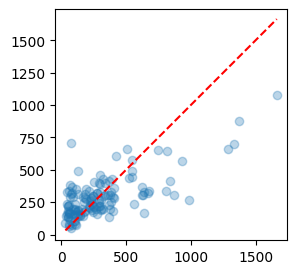

In [89]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root mean Squared Error: {rmse}")

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(y_test,y_pred,alpha=0.3)
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')
ax.axis('equal');